<h2>Import Library<h2>

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os
from PIL import Image
import random

<h2>Alamat Direktori<h2>

In [4]:
# sapi
# direktori train test
train_dir= r'D:\Bangkit 2023\CAPSTONE\sapiseimbang\train'
test_dir= r'D:\Bangkit 2023\CAPSTONE\sapiseimbang\test'

<h2>Exploratory Data Analysis<h2>

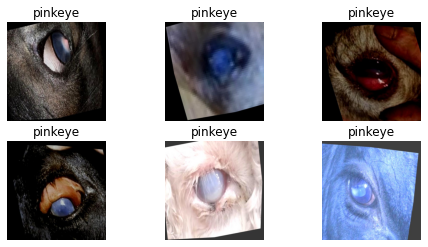

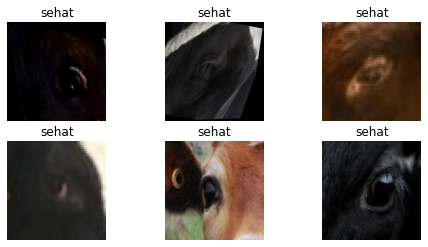

In [5]:
# list nama kelas
class_name = 'pinkeye'
class_name2 = 'sehat'

# list path gambar pada kelas yang dipilih
image_paths = os.listdir(os.path.join(train_dir, class_name))
image_paths2 = os.listdir(os.path.join(train_dir, class_name2))

# memilih 6 gambar secara acak dari kelas yang dipilih
image_paths = random.sample(image_paths, 6)
image_paths2 = random.sample(image_paths2, 6)

# menampilkan 6 gambar dari kelas yang dipilih
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name, image_paths[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name}")
    ax.axis('off')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name2, image_paths2[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name2}")
    ax.axis('off')
plt.show()

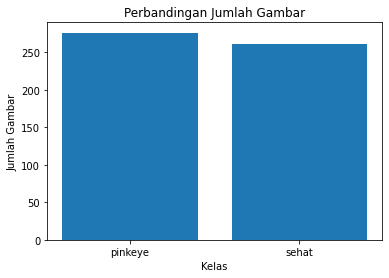

jumlah gambar sapi pinkeye =  276
jumlah gambar sapi sehat =  261


In [6]:
class_names = ['pinkeye', 'sehat']

# menghitung jumlah gambar pada setiap kelas
num_images = []
for class_name in class_names:
    num_images.append(len(os.listdir(os.path.join(train_dir, class_name))))

# menampilkan grafik perbandingan jumlah gambar pada dua kelas
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(class_names, num_images)
ax.set_title('Perbandingan Jumlah Gambar')
ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
plt.show()
print('jumlah gambar sapi pinkeye = ',num_images[0])
print('jumlah gambar sapi sehat = ',num_images[1])

<h2>Preprocessing Image<h2>

In [7]:
# ukuran gambar dan batch nantinya
image_size = 224
batch_size = 32

In [8]:
# augmentasi data train
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=24,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   zoom_range=0.2,
                                   horizontal_flip=False)

# yang tes cmn rescale aja
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# mempersiapkan data di preprosesing untuk train dan tes nantinya
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='binary')


Found 537 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


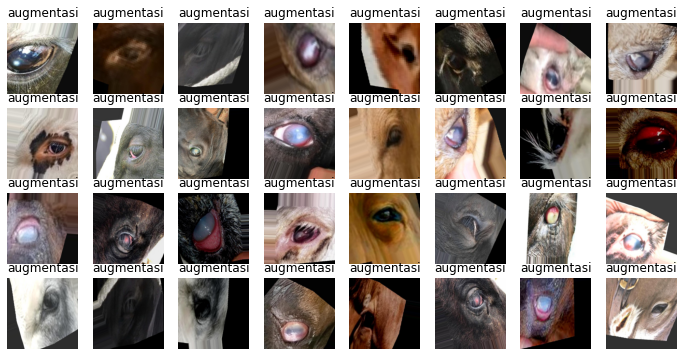

Jumlah gambar hasil augmentasi: 544


In [10]:
augmented_images, _ = train_generator.next()

# memvisualisasikan gambar setelah augmentasi
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.set_title('augmentasi')
    ax.imshow(augmented_images[i])
    ax.axis('off')
plt.show()
num_augmented_images = len(train_generator)* batch_size
print("Jumlah gambar hasil augmentasi:", num_augmented_images)

<h2>Arsitektur Transfer Learning<h2>

In [11]:
# base model transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [12]:
# atur layer basemodel agar tidak dilatih
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# layer untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


<h2>Traning Model<h2>

In [31]:
# training
num_epochs = 2
import math
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / batch_size)
)

Epoch 1/2
16/16 [==============================] - 9s 570ms/step - loss: 0.0869 - accuracy: 0.9663 - val_loss: 0.2698 - val_accuracy: 0.9643
Epoch 2/2
16/16 [==============================] - 9s 574ms/step - loss: 0.0768 - accuracy: 0.9703 - val_loss: 0.2618 - val_accuracy: 0.9643


<h2>Model Evaluation<h2>

In [32]:
test_loss, test_acc = model.evaluate(validation_generator)
print('akurasi:', test_acc)

1/1 [==============================] - 0s 427ms/step - loss: 0.2618 - accuracy: 0.9643
akurasi: 0.9642857313156128


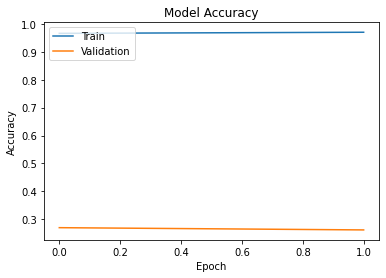

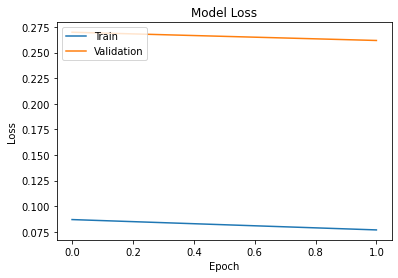

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 [==============================] - 0s 30ms/step


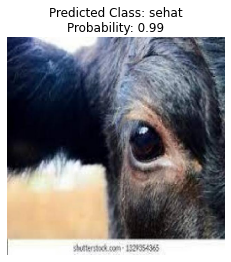

In [36]:
import matplotlib.pyplot as plt

# ambil dan prepros
test_image_path = r'D:\Bangkit 2023\CAPSTONE\sapires\test\sehat\bmbm__jpg.rf.d751e9e0eb8ecc3ac0abcf9f245852f2.jpg'
test_image = image.load_img(test_image_path, target_size=(image_size, image_size))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0

# Memprediksi
predictions = model.predict(test_image)

# probability
predicted_class = "pinkeye" if predictions[0][0] < 0.5 else "sehat" 
probability = predictions[0][0]

# tampil
plt.imshow(test_image[0])
plt.title(f'Predicted Class: {predicted_class}\nProbability: {probability:.2f}')
plt.axis('off')
plt.show()


In [37]:
model.save('model/sapifitmobilenet1.h5')